In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, SeparableConv2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D,MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # prevent overfitting
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import auc, roc_curve
from keras.regularizers import l2
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.models import Model
import tensorflow as tf
#from imblearn.over_sampling import SMOTE



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# main path
path = 'data/chest_xray/'

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

# 0 is normal and 1 is pneumonia 
for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'class'])
test_df = pd.DataFrame(test_list, columns=['image', 'class'])
val_df = pd.DataFrame(val_list, columns=['image', 'class'])

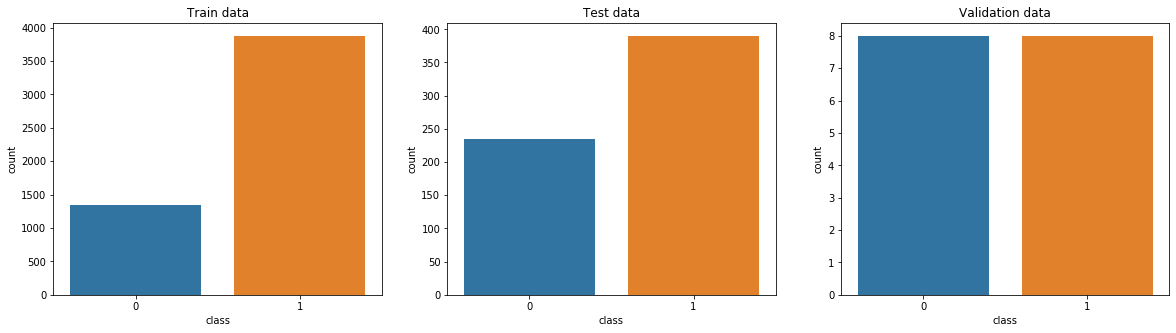

In [3]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data')

plt.show()

In [4]:
comb_df = pd.concat([train_df,val_df])
train_df_, val_df_ = train_test_split(comb_df, test_size = 0.1)
def balance(df):
    major = df[df['class'] == 1]
    minor = df[df['class'] == 0]
    minor_oversampled  = resample(minor,
                                 replace = True,
                                 n_samples = round(major['class'].value_counts()[1]*0.8),
                                 random_state = 42)
    combined_df = pd.concat([major, minor_oversampled])
    return combined_df
train_df = balance(train_df_)
val_df = balance(val_df_)

In [5]:
# pre-process & normalize image
def process_data_(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img/255.0
    img = np.reshape(img, (320, 320,-1))
    img = tf.convert_to_tensor(img[:,:,:3])

    
    return img

# write a function to split img and label into 2 separate numpy arrays
def compose_dataset_(df):
    img = []
    labels = []

    for img_path, label in df.values:
        img.append(process_data_(img_path))
        labels.append(label)
        
    return np.array(img), np.array(labels)

In [6]:
X_train, y_train = compose_dataset_(train_df)
X_test, y_test = compose_dataset_(test_df)
X_val, y_val = compose_dataset_(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (6298, 320, 320, 3), Labels shape: (6298,)
Test data shape: (624, 320, 320, 3), Labels shape: (624,)
Validation data shape: (691, 320, 320, 3), Labels shape: (691,)


In [7]:
# define generator for traing data 
image_gen = ImageDataGenerator(
            #samplewise_center = True, #set each sample mean to 0 
            #samplewise_std_normalization = True, # divide each input by its std to normalize 
            #rescale = 1./255,
            rotation_range = 30, # randomly rotate image from -30 degree to 30 degree
            width_shift_range = 0.1, #randomly shift images horizontally
            height_shift_range = 0.1, #randomly shift images vertically
            shear_range = 0.1, #randomly change shear intensity
            zoom_range = 0.2, # random zoom images
            horizontal_flip = False, # randomly flip images
            vertical_flip = False
)

# fit generator on our train features
image_gen.fit(X_train)

In [8]:
dense = Sequential()
dense.add(DenseNet121(include_top = False, weights = 'imagenet', input_shape = (320, 320,3)))
#input_tensor = Input(shape=(224,224,1)
#dense.Conv2D(3,(3,3),padding='same')(input_tensor)
for layer in dense.layers:
        layer.trainable = False
dense.add(GlobalAveragePooling2D())
dense.add(Dense(128, activation = 'relu'))
dense.add(Dense(256, activation='relu'))
dense.add(BatchNormalization())
dense.add(Dropout(0.4))
    
dense.add(Dense(64, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.3))
    
dense.add(Dense(32, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.3))
dense.add(Dense(1, activation='sigmoid'))


#dense.add(Flatten())
#dense.add(Dense(1, activation = 'sigmoid'))
#dense.layers[0].trainable=False
dense.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

In [9]:
batch_size = 32
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size
validation_steps

21

In [10]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience=5, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 3, mode='min')


In [ ]:
hist_2 = dense.fit_generator(image_gen.flow(X_train, y_train, batch_size = batch_size), #train set 
                 validation_data = (X_val, y_val), 
                 epochs = 15,
                 steps_per_epoch = steps_per_epoch,
                 verbose =1)
                 #class_weight= modified_weight_)
                 #validation_steps = 25
                 #callbacks = [early_stop,lr])

Epoch 1/15
196/196 [==============================] - 164s 774ms/step - loss: 0.4282 - accuracy: 0.8158 - val_loss: 0.1731 - val_accuracy: 0.9392
Epoch 2/15
196/196 [==============================] - 145s 736ms/step - loss: 0.2010 - accuracy: 0.9275 - val_loss: 0.0795 - val_accuracy: 0.9754
Epoch 3/15
196/196 [==============================] - 143s 729ms/step - loss: 0.1958 - accuracy: 0.9280 - val_loss: 0.0951 - val_accuracy: 0.9667
Epoch 4/15
196/196 [==============================] - 143s 728ms/step - loss: 0.1587 - accuracy: 0.9399 - val_loss: 0.1324 - val_accuracy: 0.9522
Epoch 5/15
196/196 [==============================] - 143s 727ms/step - loss: 0.1647 - accuracy: 0.9352 - val_loss: 0.6068 - val_accuracy: 0.7931
Epoch 6/15
152/196 [======================>.......] - ETA: 30s - loss: 0.1441 - accuracy: 0.9468

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('not-bad-acc-loss.jpeg')

In [ ]:
y_pred_ = dense.predict_classes(X_test, batch_size=32)

cm = confusion_matrix(y_test, y_pred_)